# Image Captioning Final Project

In this final project you will define and train an image-to-caption model, that can produce descriptions for real world images!

<img src="https://github.com/hse-aml/intro-to-dl-pytorch/blob/main/week06/images/encoder_decoder.png?raw=1" style="width:70%">

Model architecture: CNN encoder and RNN decoder. 
(https://research.googleblog.com/2014/11/a-picture-is-worth-thousand-coherent.html)

Alright, here's our plan:
* Take a pre-trained inception v3 to vectorize images
* Stack an LSTM on top of it
* Train the thing on MSCOCO

## Importing stuff and preparing data

In [3]:
%%bash

shred -u setup_colab.py

wget https://raw.githubusercontent.com/hse-aml/intro-to-dl-pytorch/main/utils/setup_colab.py -O setup_colab.py

--2021-04-17 19:20:09--  https://raw.githubusercontent.com/hse-aml/intro-to-dl-pytorch/main/utils/setup_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1649 (1.6K) [text/plain]
Saving to: ‘setup_colab.py’

     0K .                                                     100% 30.5M=0s

2021-04-17 19:20:09 (30.5 MB/s) - ‘setup_colab.py’ saved [1649/1649]



In [4]:
import setup_colab

setup_colab.setup_week06()

In [5]:
import grading
import grading_utils

grader = grading.Grader(
    assignment_key="NEDBg6CgEee8nQ6uE8a7OA",
    all_parts=["19Wpv", "E2OIL", "rbpnH", "YJR7z"]
)

In [6]:
# token expires every 30 min
COURSERA_TOKEN = 'UxeXaCk3f0NIf9No'
COURSERA_EMAIL = 'zavarovkv@gmail.com'

In [7]:
%%time

# Load dataset (vectorized images and captions)
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 234 ms, sys: 373 ms, total: 607 ms
Wall time: 610 ms


In [8]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [9]:
# split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"] + sentence.split(' ') + ["#END#"]

You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts.

We want you to count the occurences of each word so that we can decide which words to keep in our vocabulary.

In [10]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure

for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        for word in sentence:
          word_counts[word] += 1

In [11]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [12]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("19Wpv", grading_utils.test_vocab(vocab))

In [12]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


In [14]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [15]:
# Try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

## Building our neural network
As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part.

<img src="https://github.com/yunjey/pytorch-tutorial/raw/master/tutorials/03-advanced/image_captioning/png/model.png" style="width:70%">

In [16]:
import torch
from torch import nn
import torch.nn.functional as F

In [17]:
class CaptionNet(nn.Module):
    
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super().__init__()
        
        # a layer that converts conv features to initial_h (h_0) and initial_c (c_0)
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size)
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        
        self.lstm.flatten_parameters()

        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        # print(captions_emb.size())
        # print(initial_cell.size())
        # print(initial_hid.size())

        lstm_out, (hn, cn) = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)

        return logits

In [18]:
network = CaptionNet(n_tokens)

In [19]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [20]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float tensor
    """
    
    # captions for input - all except last because we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask!
    # Make sure that predicting next tokens after EOS do not contribute to loss
    # You can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    batch_size, caption_len = captions_ix_next.size()
    
    criterion = nn.CrossEntropyLoss()
    loss = criterion(logits_for_next.view(batch_size*caption_len, -1), captions_ix_next.view(batch_size*caption_len))
    loss = loss.mean()
    
    return loss

In [21]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert len(dummy_loss.shape) <= 1, 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
    'loss should depend differentiably on all neural network weights'

In [22]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("rbpnH", grading_utils.test_network(network))

In [70]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

You used an invalid email or your token may have expired. Please make sure you have entered all fields correctly. Try generating a new token if the issue still persists.


## Batch generator

In [23]:
from sklearn.model_selection import train_test_split

captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(
    img_codes, captions, test_size=0.1, random_state=42
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    # sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    # get images
    batch_images = img_codes[random_image_ix]
    
    # 5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    # pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    # convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), \
        torch.tensor(batch_captions_ix, dtype=torch.int64)

In [25]:
generate_batch(img_codes, captions, 3)

(tensor([[0.6384, 0.2218, 0.4843,  ..., 0.1982, 1.3817, 0.2918],
         [0.4102, 0.5361, 0.3347,  ..., 0.0828, 0.2406, 0.5674],
         [0.8352, 0.3725, 0.4250,  ..., 0.0000, 0.1989, 0.2394]]),
 tensor([[   1,  336,   41,   24,  119,  185,   14,  370,   51,    8,  839,    6,
           159,   14,   45,  233,   12,    2],
         [   1,   24,   48,   15,  398, 2543,    7,  900,  158,    6,   24,  895,
            12,    2,    3,    3,    3,    3],
         [   1,  210,    4,   94,  107,   24,   54,   71,  691,   24, 1776,    2,
             3,    3,    3,    3,    3,    3]]))

In [26]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("E2OIL", grading_utils.test_batch(generate_batch(img_codes, captions, 3)))

In [75]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

You used an invalid email or your token may have expired. Please make sure you have entered all fields correctly. Try generating a new token if the issue still persists.


## Train and validate loop

In [27]:
from tqdm import tqdm_notebook
from IPython.display import clear_output

In [28]:
DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [29]:
network = CaptionNet(n_tokens).to(DEVICE)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

batch_size = 128
n_epochs = 100
n_batches_per_epoch = 50
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [30]:
for epoch in range(n_epochs):
    
    train_loss = 0
    network.train()
    for _ in tqdm_notebook(range(n_batches_per_epoch)):
        images, captions = generate_batch(train_img_codes, train_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)

        loss_t = compute_loss(network, images, captions)

        # clear old gradients; do a backward pass to get new gradients; then train with opt
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        train_loss += loss_t.detach().cpu().numpy()
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    network.eval()
    for _ in range(n_validation_batches):
        images, captions = generate_batch(val_img_codes, val_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)
        
        with torch.no_grad():
            loss_t = compute_loss(network, images, captions)

        val_loss += loss_t.detach().cpu().numpy()

    val_loss /= n_validation_batches
    
    clear_output()
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")


Epoch: 99, train loss: 1.2750528168678283, val loss: 1.38271723985672
Finished!


In [31]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("YJR7z", val_loss)

In [77]:
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


## Generating caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [32]:
from beheaded_inception3 import beheaded_inception_v3

inception = beheaded_inception_v3().eval()

def generate_caption(image, caption_prefix = ('#START#',), t=1, sample=True, max_len=100):
    network2 = network.cpu().eval()

    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >= 0 and image.shape[-1] == 3
    
    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
        next_word_logits = network2.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).detach().numpy()
        
        assert len(next_word_probs.shape) == 1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word == '#END#':
            break

    return ' '.join(caption_prefix[1:-1])

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [33]:
import matplotlib.pyplot as plt
from skimage.transform import resize

# sample image
! wget https://avatars.mds.yandex.net/get-zen_doc/1578906/pub_5deb7d24a06eaf00af983448_5deb7d6643863f00ae06dc24/scale_1200 -O data/img.jpg

--2021-04-17 19:28:47--  https://avatars.mds.yandex.net/get-zen_doc/1578906/pub_5deb7d24a06eaf00af983448_5deb7d6643863f00ae06dc24/scale_1200
Resolving avatars.mds.yandex.net (avatars.mds.yandex.net)... 87.250.247.183, 87.250.247.182, 87.250.247.181, ...
Connecting to avatars.mds.yandex.net (avatars.mds.yandex.net)|87.250.247.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127270 (124K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 124.29K   320KB/s    in 0.4s    

2021-04-17 19:28:49 (320 KB/s) - ‘data/img.jpg’ saved [127270/127270]



a cat is sitting on a table .
a cat sitting on a table next to a glass of wine .
a cat sitting on top of a wooden table .
a cat is sitting on a table .
a cat is sitting on a table .


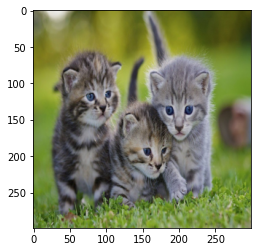

In [34]:
img = plt.imread('data/img.jpg')
img = resize(img, (299, 299))

plt.imshow(img)

for i in range(5):
    print(generate_caption(img, t=5.))

# Staff graded assignment tasks

Now you are going to train the network and estimate it's quality on checkpoints.

1. Train the network for 6 epoches (set n_batches_per_epoch to such value, that with batch_size you iterate over the whole dataset at one epoch, you should increase n_validation_batches to validate more accurately), find good and bad annotation examples. What loss values have you achieved?
1. Continue training until 12 epoch. What happened to the loss value? Search for examples, that have improved their captions in comparison to 6 epoch training.
1. Train the network until convergence. How many epoches do you need?
1. Mobile devices are not very powerfull. Try reducing network size (emb_size=64, lstm_units=128), how it affected network quality after 12 epoches in comparison to original network? And visually?
1. Collect at least 10 images that you like to test our network on.
    - Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
    - Make sure it works okay on simple images before going to something more complex
    - Photos, not animation/3d/drawings, unless you want to train CNN network on anime
    - Mind the aspect ratio
    - Photos should not be from MSCOCO! Collect some data yourself, take anything you find worth testing on

### Training tips

* If training loss has become close to 0 or model produces garbage, double-check that you're predicting next words, not current or t+2'th words
* If the model generates fluent captions that have nothing to do with the images
    * this may be due to recurrent net not receiving image vectors.
    * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
    * finally, you may just need to train the model a bit more
* Crossentropy is a poor measure of overfitting
    * Model can overfit validation crossentropy but keep improving validation quality.
    * Use human (manual) evaluation or try automated metrics: cider or bleu
    
* We recommend you to periodically evaluate the network using the next "apply trained model" block
    * its safe to interrupt training, run a few examples and start training again
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0

## Images to test on

We have downloaded 30 images from validation set of MSCOCO, they are located in `data` folder and named `img_i.jpg` for i from 0 to 29. You should use them to measure your network quality during checkpoints.

In [35]:
imgs = []

for i in range(0, 29):
  img_name = f'data/img_{i}'
  img = plt.imread(img_name)
  img = resize(img, (299, 299))

  imgs.append(img)

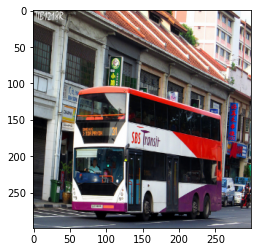

In [36]:
plt.imshow(imgs[0])

## First task

Train the network for 6 epoches (set n_batches_per_epoch to such value, that with batch_size you iterate over the whole dataset at one epoch, you should increase n_validation_batches to validate more accurately), find good and bad annotation examples. What loss values have you achieved?

In [38]:
network = CaptionNet(n_tokens).to(DEVICE)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

batch_size = 128
n_epochs = 6
n_batches_per_epoch = 2
n_validation_batches = 1

In [ ]:
### USE CODE FROM ABOVE (MAIN TRAIN AND VAL LOOP)
### USE CODE FROM ABOVE (GENERATING CAPTION FOR IMAGES)

In [39]:
for epoch in range(n_epochs):
    
    train_loss = 0
    network.train()
    for _ in tqdm_notebook(range(n_batches_per_epoch)):
        images, captions = generate_batch(train_img_codes, train_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)

        loss_t = compute_loss(network, images, captions)

        # clear old gradients; do a backward pass to get new gradients; then train with opt
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        train_loss += loss_t.detach().cpu().numpy()
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    network.eval()
    for _ in range(n_validation_batches):
        images, captions = generate_batch(val_img_codes, val_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)
        
        with torch.no_grad():
            loss_t = compute_loss(network, images, captions)

        val_loss += loss_t.detach().cpu().numpy()

    val_loss /= n_validation_batches
    
    clear_output()
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")


Epoch: 5, train loss: 5.104619979858398, val loss: 3.5523948669433594
Finished!


crusted windsurfer utilizing blend foraging wrappers tan shaded #PAD# head someones remain cityscape formally ceilings everything #PAD# dual #PAD# trick ketchup whole protein #PAD# #PAD# #PAD# sink #PAD# cat pets #PAD# tiny #PAD# narrow friends disassembled benz #PAD# quaint digitally #PAD# #PAD# great sole icicles dog team's using of newscast reacts wrapped embrace roll talking arms cooking muscles trails featured redone lanes ontop curiosity preening fame decided grasses cargo dandelions seal #PAD# yells park owners shown exhibition plate choice arrows ranch #PAD# indicator reaching sinks kettles #PAD# darkness diagram #PAD# #PAD# spaghetti videogame cook bat bolts free pretend frisbees


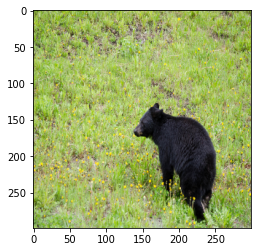

In [40]:
plt.imshow(imgs[1])
print(generate_caption(imgs[1]))

## Second task

Continue training until 12 epoch. What happened to the loss value? Search for examples, that have improved their captions in comparison to 6 epoch training.

In [41]:
network = CaptionNet(n_tokens).to(DEVICE)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

batch_size = 128
n_epochs = 12
n_batches_per_epoch = 3
n_validation_batches = 1

In [99]:
### USE CODE FROM ABOVE (MAIN TRAIN AND VAL LOOP)
### USE CODE FROM ABOVE (GENERATING CAPTION FOR IMAGES)

In [42]:
for epoch in range(n_epochs):
    
    train_loss = 0
    network.train()
    for _ in tqdm_notebook(range(n_batches_per_epoch)):
        images, captions = generate_batch(train_img_codes, train_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)

        loss_t = compute_loss(network, images, captions)

        # clear old gradients; do a backward pass to get new gradients; then train with opt
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        train_loss += loss_t.detach().cpu().numpy()
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    network.eval()
    for _ in range(n_validation_batches):
        images, captions = generate_batch(val_img_codes, val_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)
        
        with torch.no_grad():
            loss_t = compute_loss(network, images, captions)

        val_loss += loss_t.detach().cpu().numpy()

    val_loss /= n_validation_batches
    
    clear_output()
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")


Epoch: 11, train loss: 3.0857385794321694, val loss: 3.1287078857421875
Finished!


woman child two , talking . at very shortly


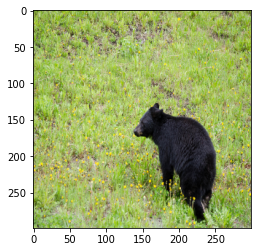

In [45]:
plt.imshow(imgs[1])
print(generate_caption(imgs[1]))

## Third task

Train the network until convergence. How many epoches do you need?

In [46]:
network = CaptionNet(n_tokens).to(DEVICE)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

batch_size = 128
n_epochs = 100
n_batches_per_epoch = 50
n_validation_batches = 5

In [47]:
for epoch in range(n_epochs):
    
    train_loss = 0
    network.train()
    for _ in tqdm_notebook(range(n_batches_per_epoch)):
        images, captions = generate_batch(train_img_codes, train_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)

        loss_t = compute_loss(network, images, captions)

        # clear old gradients; do a backward pass to get new gradients; then train with opt
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        train_loss += loss_t.detach().cpu().numpy()
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    network.eval()
    for _ in range(n_validation_batches):
        images, captions = generate_batch(val_img_codes, val_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)
        
        with torch.no_grad():
            loss_t = compute_loss(network, images, captions)

        val_loss += loss_t.detach().cpu().numpy()

    val_loss /= n_validation_batches
    
    clear_output()
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")


Epoch: 99, train loss: 1.2894742476940155, val loss: 1.356816792488098
Finished!


two buses and trucks at the side of the terminal with their arrows walk to allow outside .


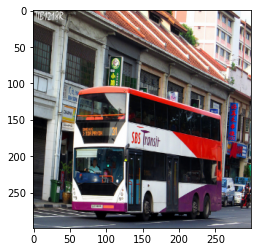

In [48]:
plt.imshow(imgs[0])
print(generate_caption(imgs[0]))

two bears are drinking stalks each other from a branch


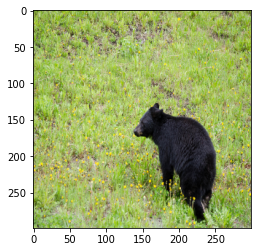

In [49]:
plt.imshow(imgs[1])
print(generate_caption(imgs[1]))

a brown appliance and a motorcycle down on a bar


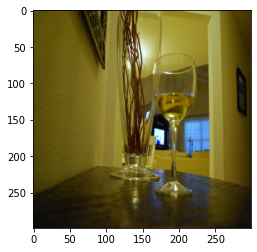

In [50]:
plt.imshow(imgs[2])
print(generate_caption(imgs[2]))

a man is standing on a patio looking very glass .


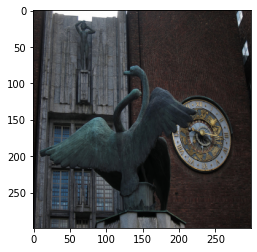

In [51]:
plt.imshow(imgs[3])
print(generate_caption(imgs[3]))

## Fourth task

 Mobile devices are not very powerfull. Try reducing network size (emb_size=64, lstm_units=128), how it affected network quality after 12 epoches in comparison to original network? And visually?

In [52]:
network = CaptionNet(n_tokens=n_tokens, emb_size=64, lstm_units=128).to(DEVICE)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

batch_size = 128
n_epochs = 12
n_batches_per_epoch = 6
n_validation_batches = 3

In [ ]:
### USE CODE FROM ABOVE (MAIN TRAIN AND VAL LOOP)
### USE CODE FROM ABOVE (GENERATING CAPTION FOR IMAGES)

In [53]:
for epoch in range(n_epochs):
    
    train_loss = 0
    network.train()
    for _ in tqdm_notebook(range(n_batches_per_epoch)):
        images, captions = generate_batch(train_img_codes, train_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)

        loss_t = compute_loss(network, images, captions)

        # clear old gradients; do a backward pass to get new gradients; then train with opt
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        train_loss += loss_t.detach().cpu().numpy()
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    network.eval()
    for _ in range(n_validation_batches):
        images, captions = generate_batch(val_img_codes, val_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)
        
        with torch.no_grad():
            loss_t = compute_loss(network, images, captions)

        val_loss += loss_t.detach().cpu().numpy()

    val_loss /= n_validation_batches
    
    clear_output()
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")


Epoch: 11, train loss: 2.5116177002588906, val loss: 2.702650864919027
Finished!


a in vase narrow flowers in the to . #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# jacket #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#


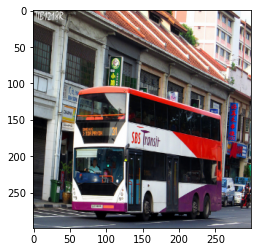

In [54]:
plt.imshow(imgs[0])
print(generate_caption(imgs[0]))

a wall a is light next behind to . around #PAD#


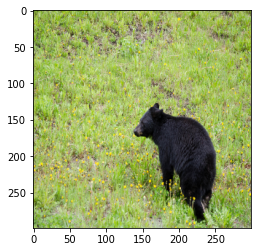

In [56]:
plt.imshow(imgs[1])
print(generate_caption(imgs[1]))

man together cell at cake old the #PAD#


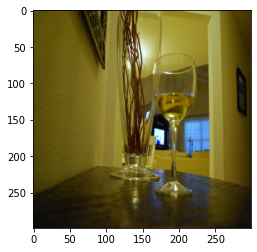

In [58]:
plt.imshow(imgs[2])
print(generate_caption(imgs[2]))

## Fifth task

Collect at least 10 images that you like to test our network on.
   - Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
   - Make sure it works okay on simple images before going to something more complex
   - Photos, not animation/3d/drawings, unless you want to train CNN network on anime
   - Mind the aspect ratio
   - Photos should not be from MSCOCO! Collect some data yourself, take anything you find worth testing on

In [ ]:
### YOUR IMAGES COLLECTING CODE
### YOUR CAPTIONS GENERATING CODE

In [59]:
# images

! wget https://www.freepdfconvert.com/img/testimonial/thomas-papoulakis.jpg -O data/my_img_0
! wget https://img.aeroexpo.com.ru/images_ar/photo-m2/173550-15583093.jpg -O data/my_img_1
! wget https://images.squarespace-cdn.com/content/v1/5693a6c09cadb61a0a1ca64d/1452618426317-63DXC7DALGQFS3HXD7EY/ke17ZwdGBToddI8pDm48kPgmzCTe86Hf5cZE7733rjd7gQa3H78H3Y0txjaiv_0fDoOvxcdMmMKkDsyUqMSsMWxHk725yiiHCCLfrh8O1z5QHyNOqBUUEtDDsRWrJLTmxyXvWKJWcy4t4TJMVJdPep4dN0Z0v9_Sslj2jPY59mXyqMuXtVPOT8TS2F0esNo9/Elephant+6.jpg?format=300w -O data/my_img_2
! wget https://www.be-in.ru/media/beingallery/uploads/staticcorestatic/2019/04/10/mango-man-ss19-01.jpg.300x300_q77_box-0%2C88%2C1108%2C884_crop.jpg -O data/my_img_3
! wget https://autoelektrik29.ru/wp-content/uploads/2019/05/xoAr2EB58x6Q-300x300.jpg.pagespeed.ic.ZIK1rez6x1.jpg -O data/my_img_4
! wget https://maxi-flowers.ru/wp-content/uploads/2019/10/Soblazn-300x300.jpg -O data/my_img_5
! wget https://upload.wikimedia.org/wikipedia/commons/6/6f/The_ruins_of_the_house_of_culture_Energetik.jpg -O data/my_img_6
! wget https://autocuby.eu/wp-content/uploads/2020/03/cuby-bus-midibus-2-300x300.jpg -O data/my_img_7
! wget https://www.be-in.ru/media/beingallery/uploads/staticcorestatic/2020/03/16/House-ss20-10.jpg.300x300_q77_box-0%2C120%2C959%2C810_crop.jpg -O data/my_img_8
! wget https://acj-car.ru/wp-content/uploads/3947071-300x300.jpg -O data/my_img_9

--2021-04-17 19:34:14--  https://www.freepdfconvert.com/img/testimonial/thomas-papoulakis.jpg
Resolving www.freepdfconvert.com (www.freepdfconvert.com)... 159.8.243.102
Connecting to www.freepdfconvert.com (www.freepdfconvert.com)|159.8.243.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13489 (13K) [image/jpeg]
Saving to: ‘data/my_img_0’

data/my_img_0       100%[===================>]  13.17K  --.-KB/s    in 0s      

2021-04-17 19:34:14 (278 MB/s) - ‘data/my_img_0’ saved [13489/13489]

--2021-04-17 19:34:15--  https://img.aeroexpo.com.ru/images_ar/photo-m2/173550-15583093.jpg
Resolving img.aeroexpo.com.ru (img.aeroexpo.com.ru)... 54.70.206.13
Connecting to img.aeroexpo.com.ru (img.aeroexpo.com.ru)|54.70.206.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9877 (9.6K) [image/jpeg]
Saving to: ‘data/my_img_1’

data/my_img_1       100%[===================>]   9.65K  --.-KB/s    in 0s      

2021-04-17 19:34:16 (180 MB/s) - ‘data/m

In [77]:
my_imgs = []

for i in range(0, 10):
  img_name = f'data/my_img_{i}'
  img = plt.imread(img_name)
  img = resize(img, (299, 299))

  my_imgs.append(img)

a two bouquet end buildings in with . #PAD# #UNK#


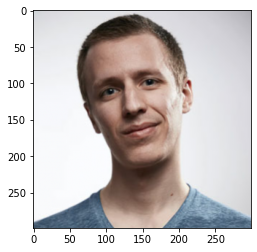

In [64]:
plt.imshow(my_imgs[0])
print(generate_caption(imgs[0]))

a tennis a tennis of childs window


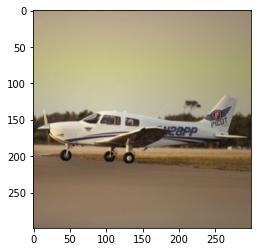

In [65]:
plt.imshow(my_imgs[1])
print(generate_caption(imgs[1]))

a pink board pizzas train some


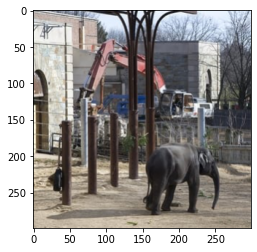

In [67]:
plt.imshow(my_imgs[2])
print(generate_caption(imgs[2]))

a badly green different a matter on standing the water .


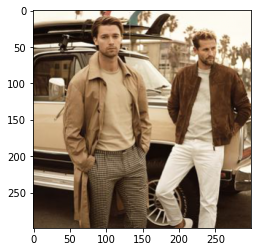

In [68]:
plt.imshow(my_imgs[3])
print(generate_caption(imgs[3]))

clock a empty and with injured face bench . field a


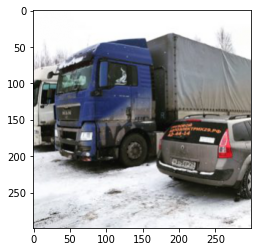

In [70]:
plt.imshow(my_imgs[4])
print(generate_caption(imgs[4]))

a kitchen advertises field a top pan carrots ,


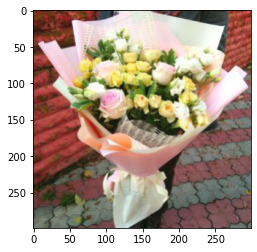

In [71]:
plt.imshow(my_imgs[5])
print(generate_caption(imgs[5]))

connect skiing a person black pizza front empty some a at


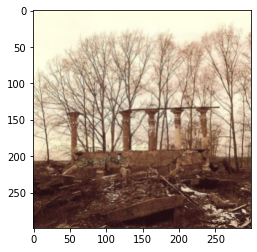

In [72]:
plt.imshow(my_imgs[6])
print(generate_caption(imgs[6]))

beach man can on the chairs in #PAD# woman background hydrant


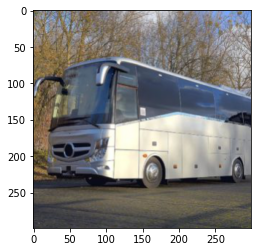

In [74]:
plt.imshow(my_imgs[7])
print(generate_caption(imgs[7]))

young is covered of kicks a in looking .


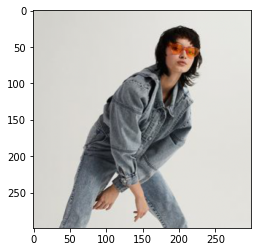

In [75]:
plt.imshow(my_imgs[8])
print(generate_caption(imgs[8]))

carnival in up scissors men giraffe


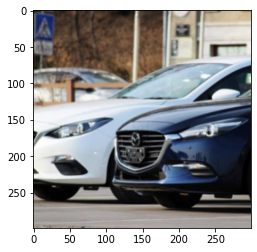

In [78]:
plt.imshow(my_imgs[9])
print(generate_caption(imgs[9]))